In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import queue
import contextlib
import time
import PyQt5

In [2]:
# pip install PyQt5

#### Import the logs (backlog + incoming) from .CSV and create DataFrame

In [71]:
log_df = pd.read_csv('defectRemediation_log_simulation_vPrototype_v2.csv', index_col='ID')
log_df['Timestamp'] = pd.to_datetime(log_df['Timestamp'], format='%Y-%d-%m %H:%M:%S')
# log_df
incoming_log_df = pd.read_csv('defectRemediation_log_incoming_simulation_vPrototype.csv', index_col='ID')
incoming_log_df['Timestamp'] = pd.to_datetime(incoming_log_df['Timestamp'], format='%Y-%d-%m %H:%M:%S')
# incoming_log_df

In [72]:
class logEntry:
    def __init__(self, defect_id, state, control_type, sub_log_df):
        self.defect_id = defect_id
        self.state = state
        self.control_type = control_type
        self.sub_log_df = sub_log_df

    # def stateNew(self):
    ## create new delta table row

    def stateAssign(self, empirical_dict):
        timestamp_new = sub_log_df.loc[(sub_log_df['Defect_ID']==self.defect_id) & (sub_log_df['State']=='new')]['Timestamp'].iloc[0]
        timestamp_assign = sub_log_df.loc[(sub_log_df['Defect_ID']==self.defect_id) & (sub_log_df['State']==self.state)]['Timestamp'].iloc[0]
        
        ## time between assign and new (hrs)
        delta_new_assign = self.computeDelta(timestamp_new, timestamp_assign)

        ## append value to empirical dict
        empirical_dict[self.control_type]['delta_new_assign'].append(delta_new_assign)
        return delta_new_assign, empirical_dict

    def stateInProgress(self, empirical_dict):
        timestamp_assign = sub_log_df.loc[(sub_log_df['Defect_ID']==self.defect_id) & (sub_log_df['State']=='assign')]['Timestamp'].iloc[0]
        timestamp_inprogress = sub_log_df.loc[(sub_log_df['Defect_ID']==self.defect_id) & (sub_log_df['State']==self.state)]['Timestamp'].iloc[0]
        
        ## time between in-progress and assign (hrs)
        delta_assign_inprogress = self.computeDelta(timestamp_assign, timestamp_inprogress)
        
        ## append value to empirical dict
        empirical_dict[self.control_type]['delta_assign_inprogress'].append(delta_assign_inprogress)
        return delta_assign_inprogress, empirical_dict

    def stateClosed(self, empirical_dict):
        timestamp_new = sub_log_df.loc[(sub_log_df['Defect_ID']==self.defect_id) & (sub_log_df['State']=='new')]['Timestamp'].iloc[0]
        timestamp_inprogress = sub_log_df.loc[(sub_log_df['Defect_ID']==self.defect_id) & (sub_log_df['State']=='in-progress')]['Timestamp'].iloc[0]
        timestamp_closed = sub_log_df.loc[(sub_log_df['Defect_ID']==self.defect_id) & (sub_log_df['State']==self.state)]['Timestamp'].iloc[0]
        
        ## time between closed and in-progress, and closed and new (hrs)
        delta_inprogress_closed = self.computeDelta(timestamp_inprogress, timestamp_closed)
        delta_new_closed = self.computeDelta(timestamp_new, timestamp_closed)
        
        ## append value to empirical dict
        empirical_dict[self.control_type]['delta_inprogress_closed'].append(delta_inprogress_closed)
        empirical_dict[self.control_type]['delta_new_closed'].append(delta_new_closed)
        return delta_inprogress_closed, delta_new_closed, empirical_dict

    # def updateDeltaTable(self, delta_state_state):
    def computeDelta(self, timestamp_older, timestamp_newer):
        ## Computes the time delta (in hrs) as timestamp_newer - timestamp_older
        delta_timestamps = timestamp_newer - timestamp_older
        delta_timestamps = round(delta_timestamps.total_seconds()/3600, 3)
        return delta_timestamps

In [73]:
class buildHistories:
    def __init__(self, control_type, sub_deltas_df, sub_log_df2, incoming_dict, empirical_dict):
        self.control_type = control_type
        self.sub_deltas_df= sub_deltas_df
        self.sub_log_df2 = sub_log_df2
        self.incoming_dict = incoming_dict
        self.empirical_dict = empirical_dict

    def updateFigures(self):
        fig, axs = plt.subplots(1, 4, figsize=(16, 4))
        axs[0].plot(range(1,len(self.sub_deltas_df['Delta_New_Assign'])+1), self.sub_deltas_df['Delta_New_Assign'], 'k-o', markersize=6)
        axs[0].set_ylabel('time (hrs)')
        axs[0].set_title('Delta_New_Assign', loc='left', fontsize=10)

        axs[1].plot(range(1,len(self.sub_deltas_df['Delta_Assign_InProgress'])+1), self.sub_deltas_df['Delta_Assign_InProgress'], 'k-o', markersize=6)
        axs[1].set_title('Delta_Assign_InProgress', loc='left', fontsize=10)

        axs[2].plot(range(1,len(self.sub_deltas_df['Delta_InProgress_Closed'])+1), self.sub_deltas_df['Delta_InProgress_Closed'], 'k-o', markersize=6)
        axs[2].set_title('Delta_InProgress_Closed', loc='left', fontsize=10)

        axs[3].plot(range(1,len(self.sub_deltas_df['Delta_New_Closed'])+1), self.sub_deltas_df['Delta_New_Closed'], 'k-o', markersize=6)
        axs[3].set_title('Delta_New_Closed', loc='left', fontsize=10)
    
        fig.text(0.5, 0.95, f'{self.control_type}', ha='center', fontsize=12)
        plt.savefig(f'{self.control_type}_fig.png', bbox_inches='tight')
        plt.close()

    # def deltaDistributions(self):

    def updateIncoming(self):
        for day in self.sub_log_df2["Date"].unique(): # TO DO - how to track date outside of logs (i.e. if no state changes/defects generated, dates do not appear in logs 
            sub_log_df2_date = self.sub_log_df2.query('Date == @day')['Hour'].value_counts()
            incoming_defects = [sub_log_df2_date.loc[i] if i in sub_log_df2_date.index else 0 for i in range(0,24)]
            self.incoming_dict[control_type].update({day: incoming_defects})
            self.empirical_dict[control_type]['incoming_per_hour'] = self.empirical_dict[control_type]['incoming_per_hour'] + self.incoming_dict[control_type][day]
        return self.incoming_dict, self.empirical_dict

In [74]:
# master dictionary with tracked empirical data to build distributions
empirical_dict = {}
incoming_dict = {}
control_types = log_df['Control_Type'].unique()
for control_type in control_types:
    empirical_dict[control_type] = {'incoming_per_hour': [],
                                    'delta_new_assign': [],
                                    'delta_assign_inprogress': [],
                                    'delta_inprogress_closed': [],
                                    'delta_new_closed': []
                                   }
    incoming_dict[control_type] = {}

# initializing empty delta table
deltas_df = pd.DataFrame(columns=['Defect_ID','Control_Type','Delta_New_Assign','Delta_Assign_InProgress','Delta_InProgress_Closed', 'Delta_New_Closed'])

In [75]:
# appending entries of previous 24h to the processing queue
processing_queue = queue.Queue()
for row in log_df.iterrows():
    with contextlib.suppress(IndexError):
        processing_queue.put(row[0], block=False)

processing_queue.qsize()

116

In [76]:
## process entries in previous 24h one at a time
while processing_queue.qsize() > 0: # takes previous 24h of data
# for _ in range(processing_queue.qsize()):
    with contextlib.suppress(queue.Empty):
        row_id = processing_queue.get(block=False)
# for row in log_df.iterrows():
    
    ## Add new columns 'Date' and 'Hour' for tracking incoming defects per hour 
    log_df.loc[row_id, 'Date'] = log_df.loc[row_id, 'Timestamp'].date()
    log_df.loc[row_id, 'Hour'] = log_df.loc[row_id, 'Timestamp'].hour

    ## Extract the defect ID, state, and control type of the log entry, and any other entries with the same defect ID (sub_log_df)
    defect_id = log_df.loc[row_id, 'Defect_ID']
    state = log_df.loc[row_id, 'State']
    control_type = log_df.loc[row_id, 'Control_Type']
    # timestamp = log_df.loc[row[0], 'Timestamp']
    sub_log_df = log_df.query('Defect_ID == @defect_id')

    ## Initialize class logEntry
    log_entry = logEntry(defect_id, state, control_type, sub_log_df)

    if state == 'new':
        ## append to delta table with defect_ID and control_type
        try: ## deltas_df contains some entries, add onto it
            Last_ID_processed = deltas_df.index[-1]
            index = Last_ID_processed + 1
        except IndexError: ## deltas_df is empty, start from beginning
            index = 0 
        deltas_df.loc[index, ['Defect_ID', 'Control_Type']] = [defect_id, control_type]
        ####### Should deltas_df be passed to a method and updated in the class?
    
    if state =='assign':
        delta_new_assign, empirical_dict = log_entry.stateAssign(empirical_dict)
        deltas_df.loc[deltas_df['Defect_ID'] == defect_id, 'Delta_New_Assign'] = delta_new_assign
        
        # log_entry.updateDeltaTable(delta_new_assign, sub_deltas_df)
    
    elif state == 'in-progress':
        delta_assign_inprogress, empirical_dict = log_entry.stateInProgress(empirical_dict)
        deltas_df.loc[deltas_df['Defect_ID'] == defect_id, 'Delta_Assign_InProgress'] = delta_assign_inprogress
    
    elif state == 'closed':
        delta_inprogress_closed, delta_new_closed, empirical_dict = log_entry.stateClosed(empirical_dict)
        deltas_df.loc[deltas_df['Defect_ID'] == defect_id, ['Delta_InProgress_Closed', 'Delta_New_Closed']] = [delta_inprogress_closed, delta_new_closed]

In [77]:
## update figures and histograms with last 24h data
for control_type in control_types:
    ## if state == 'closed', all deltas for a given defect have been computed - extract all rows of control_type and keep only those with state == 'closed' 
    sub_deltas_df = deltas_df.query('Control_Type == @control_type').dropna()

    ## only need state == 'new' for incoming defects per hour histograms
    sub_log_df2 = log_df.query('(Control_Type == @control_type) and (State == "new")')

    histories = buildHistories(control_type, sub_deltas_df, sub_log_df2, incoming_dict, empirical_dict)
    if sub_deltas_df.empty == 0:
        histories.updateFigures() ## update the figure for this control type
    incoming_dict, empirical_dict = histories.updateIncoming() ## update incoming defect distributions for this control_type

In [78]:
empirical_dict

{'ACC03': {'incoming_per_hour': [1,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   2,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   4,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   1,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  'delta_new_assign': [0.224,
   0.845,
   0.271,
   0.329,
   1.506,
   15.869,
   16.184,
   17.233,
   18.747,
   24.622],
  'delta_assign_inprogress': [0.063,
   0.466,
   0.206,
   3.382,
   2.044,
   0.028,
   3.04,
   1.986,
   1.334,
   45.928],
  'delta_inprogress_closed': [0.204,
   0.731,
   2.983,
   4.347,
   2.186,
   3.781,
   4.576,
   4.589,
   3.745,
   8.219],
  'delta_ne

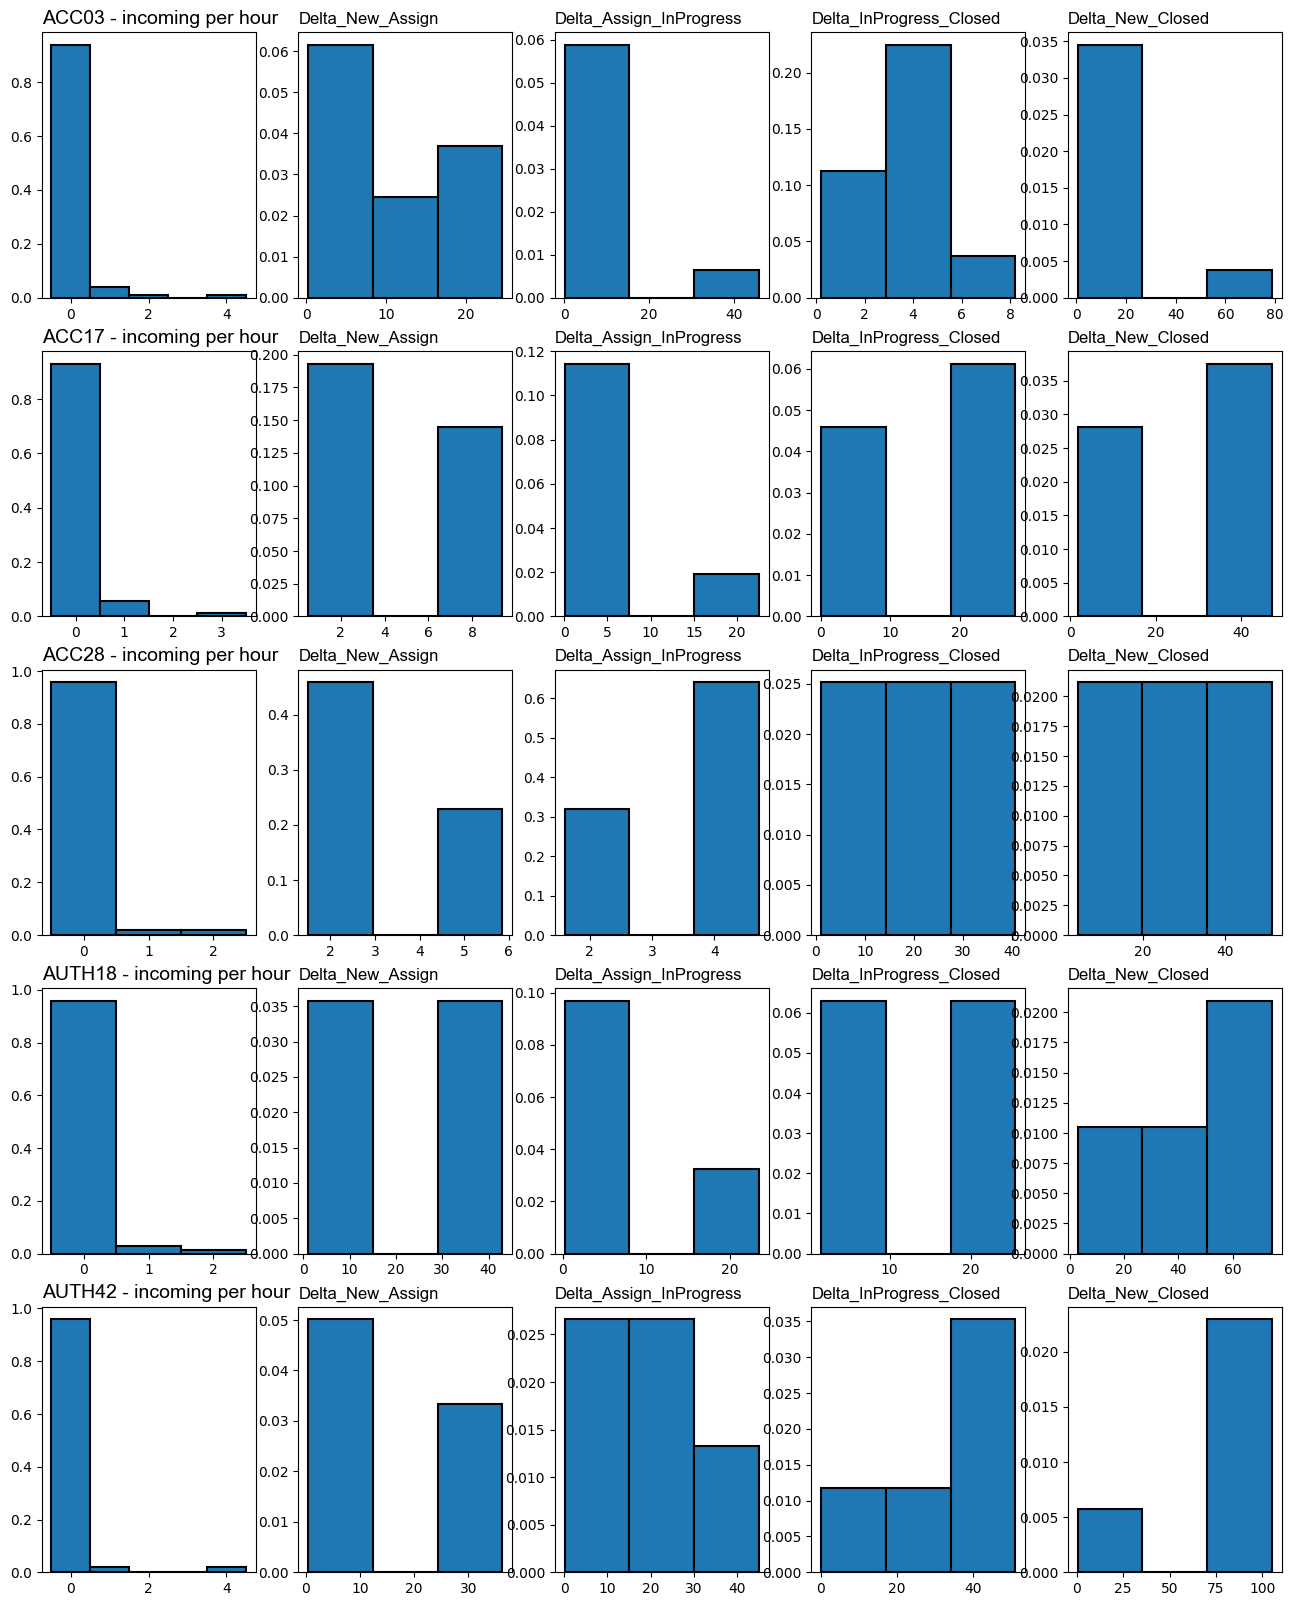

In [86]:
csfont = {'fontname':'Arial'}
fig, axs = plt.subplots (len(empirical_dict.keys()), 5, figsize=(16,20))
for index, value in enumerate(empirical_dict.keys()):
    data = np.array(empirical_dict[value]['incoming_per_hour'])
    unique_values = np.unique(data)
    if np.all(unique_values) == 0:
        d = 1
    else:
        d = np.diff(unique_values).min()
    left_of_first_bin = data.min() - float(d)/2
    right_of_last_bin = data.max() + float(d)/2
    axs[index][0].hist(data, np.arange(left_of_first_bin, right_of_last_bin + d, d), edgecolor='black', linewidth=1.5, density=True)
    axs[index][0].set_title(f'{value} - incoming per hour', loc='left', fontsize=14, **csfont)
    axs[index][1].hist(empirical_dict[value]['delta_new_assign'], bins=3, edgecolor='black', linewidth=1.5, density=True)
    axs[index][2].hist(empirical_dict[value]['delta_assign_inprogress'], bins=3, edgecolor='black', linewidth=1.5, density=True)
    axs[index][3].hist(empirical_dict[value]['delta_inprogress_closed'], bins=3, edgecolor='black', linewidth=1.5, density=True)
    axs[index][4].hist(empirical_dict[value]['delta_new_closed'], bins=3, edgecolor='black', linewidth=1.5, density=True)

    axs[index][1].set_title('Delta_New_Assign', loc='left', fontsize=12, **csfont)
    axs[index][2].set_title('Delta_Assign_InProgress', loc='left', fontsize=12, **csfont)
    axs[index][3].set_title('Delta_InProgress_Closed', loc='left', fontsize=12, **csfont)
    axs[index][4].set_title('Delta_New_Closed', loc='left', fontsize=12, **csfont)


plt.show()

#### Stop here ####

In [125]:
current_date = log_df.iloc[0]['Date'] # for computing incoming defects per hour distributions
current_hour = log_df.iloc[0]['Timestamp'].hour # for computing incoming defects per hour distributions 
log_df.query('(Date == @current_date) and (Hour == @current_hour) and (State == "new")')

,Defect_ID,Control_Type,State,Date,Timestamp,Hour
ID,,,,,,
1,1,ACC03,new,2025-16-05,2025-05-16 00:05:31,0.0
2,2,ACC17,new,2025-16-05,2025-05-16 00:12:42,0.0
3,3,ACC28,new,2025-16-05,2025-05-16 00:13:44,0.0


In [ ]:
# update figures method
# update distributions method

In [40]:
sub_deltas_df = deltas_df.query('Control_Type == "ACC03"').dropna()

In [49]:
range(1,len(sub_deltas_df['Delta_New_Assign'])+1)

range(1, 11)

In [48]:
len(sub_deltas_df['Delta_New_Assign'])

10

## Creating Delta table to track time b/w state changes

In [7]:
deltas_df = pd.DataFrame(columns=['Defect_ID','Control_Type','Delta_New_Assign','Delta_Assign_InProgress','Delta_InProgress_Closed', 'Delta_New_Closed'])

In [8]:
try: # deltas_df contains some entries, add onto it
    Last_ID_processed = deltas_df.index[-1]
    index = Last_ID_processed + 1
except IndexError: # deltas_df is empty, start from beginning
    index = 0 

In [9]:
# master dictionary with tracked empirical data to build distributions
empirical_dict = {}
incoming_dict = {}
figure_id_dict = {}
figure_id = 0
control_types = log_df['Control_Type'].unique()
for control_type in control_types:
    empirical_dict[control_type] = {'incoming_per_hour': [],
                                    'delta_new_assign': [],
                                    'delta_assign_inprogress': [],
                                    'delta_inprogress_closed': [],
                                    'delta_new_closed': []
                                   }
    incoming_dict[control_type] = {}
    figure_id_dict[control_type] = figure_id
    figure_id += 1

In [10]:
%matplotlib qt

In [11]:
t_end = 50

In [12]:
# fig, axs = plt.subplots (1, len(empirical_dict.keys()), figsize=(16,20))
fig, ax = plt.subplots(1, 4, figsize=(16, 4))
for _ in range(processing_queue.qsize()):
    #### PULL DEFECT TO PROCESS - IN CHRONOLOGICAL ORDER OF STATE == "CLOSED" ####
    # if processing_queue.qsize() > 0:
    with contextlib.suppress(queue.Empty):
        defect_id = processing_queue.get(block=False)
        
    #### Recover timestamps for each state change ####
    timestamp_new = log_df.loc[(log_df['Defect_ID']==defect_id) & (log_df['State']=='new')]['Timestamp'].iloc[0] # OR log_df.query('(Defect_ID == defect_id) and (State == "new")')['Timestamp'].iloc[0]
    timestamp_assign = log_df.loc[(log_df['Defect_ID']==defect_id) & (log_df['State']=='assign')]['Timestamp'].iloc[0]
    timestamp_inprogress = log_df.loc[(log_df['Defect_ID']==defect_id) & (log_df['State']=='in-progress')]['Timestamp'].iloc[0]
    timestamp_closed = log_df.loc[(log_df['Defect_ID']==defect_id) & (log_df['State']=='closed')]['Timestamp'].iloc[0]

    # time between assign and new (hrs)
    delta_new_assign = timestamp_assign - timestamp_new
    delta_new_assign = round(delta_new_assign.total_seconds()/3600, 3)
    
    # time between in-progress and assign (hrs)
    delta_assign_inprogress = timestamp_inprogress - timestamp_assign
    delta_assign_inprogress = round(delta_assign_inprogress.total_seconds()/3600, 3)
    
    # time between closed and in-progress (hrs)
    delta_inprogress_closed = timestamp_closed - timestamp_inprogress
    delta_inprogress_closed = round(delta_inprogress_closed.total_seconds()/3600, 3)

    # time between closed and new (hrs)
    delta_new_closed = sum([delta_new_assign, delta_assign_inprogress, delta_inprogress_closed])

    # append row to df and iterate index
    control_type = log_df.loc[log_df['Defect_ID'] == defect_id].iloc[0]['Control_Type']
    deltas_df.loc[index] = [defect_id, control_type, delta_new_assign, delta_assign_inprogress, delta_inprogress_closed, delta_new_closed]
    # delta_new_closed = deltas_df.loc[index, ['Delta_New_Assign','Delta_Assign_InProgress', 'Delta_InProgress_Closed']].sum()
    # deltas_df.loc[index, 'Delta_New_Closed'] = delta_new_closed
    
    
    #### UPDATE PLOTS ####
    # time.sleep(2)
    # print(i)
    # axs[figure_id_dict[control_type]].plot(delta_new_closed)
    if control_type == "ACC03":
        try:
            last_value = ax[0].lines[-1].get_xdata()[-1]
        except IndexError:
            last_value = 0
        # print(last_value, delta_new_closed)
        ax[0].plot(last_value+1, delta_new_assign, 'ko', markersize=6)
        ax[1].plot(last_value+1, delta_assign_inprogress, 'ko', markersize=6)
        ax[2].plot(last_value+1, delta_inprogress_closed, 'ko', markersize=6)
        ax[3].plot(last_value+1, delta_new_closed, 'ko', markersize=6)
        
    index += 1

ax[0].set_ylabel('time (hrs)')
ax[0].set_title('Delta_New_Assign', loc='left', fontsize=10)
ax[1].set_title('Delta_Assign_InProgress', loc='left', fontsize=10)
ax[2].set_title('Delta_InProgress_Closed', loc='left', fontsize=10)
ax[3].set_title('Delta_New_Closed', loc='left', fontsize=10)
fig.text(0.5, 0.95, 'ACC03', ha='center', fontsize=12)
plt.show()

In [13]:
# ax.lines[-1]

In [14]:
# figure_id_dict

In [15]:
# fig, ax = plt.subplots()
# ax.plot([1, 2, 3],[42, 28, 36])
# try:
#     last_value = plt.gca().lines[0].get_xdata()[-1]
# except IndexError:
#     last_value = 0

# last_value
    


In [ ]:
#### Incoming distributions updated periodically 
# every 20 entries
# 1st update on backlog
# 2nd update on incoming

In [ ]:
## GET CLEAN

In [ ]:
## STAY CLEAN